# Chapter7. Ensemble Learning and Rnadom Forests

## - Ensemble 
###  : 여러 예측자를 결합한 것이 하나의 최적 예측자보다 성능이 좋을 수 있다

#### (예)
- 6장에서 살펴본 Random Forest - 단순하면서도 강력한 알고리즘
    - 학습데이터를 임의의 subset으로 나눈 후 각 subset 마다 DT분류기를 학습
    - 예측시 각 DT의 결과를 결합해 가장 많은 표를 받은 클래스를 최종 예측값으로 선택 
    
### 이번 장에서는 가장 유명한 앙상블 기법인 Bagging, Boosting, Stacking등  과 RandomForests에 대해 살펴본다

## 1. Voting Classifier
<img src = 'image\ch7\ensemble.png'> 
- 각 80%정도의 성능을 가진 선형회귀분류기, SVM 분류기, RandomForest 분류기, K-NN 분류기 등의 개별 분류기를 학습한다고 가정

<img src = 'image\ch7\ensemble2.png'> 
- 간단하게 더 좋은 성능을 가진 분류기를 만드는 방법은 분류기들의 예측 클래스 중 많은 표를 받은 클래스를 선택하는 것 (hard voting)

- 실제로 Voting 분류기는 개별 분류기보다 더 좋은 정확도를 달성하는 경우가 많음 

### 각각의 분류기가 약한 학습기라도 분류기의 개수와 다양성이 충분하다면 결합을 통해 강한 분류기로 만들 수 있다

## 어떻게? 
- 예) 
    - 앞면이 나올 확률 51%, 
    - 뒷면이 나올 확률 49%인 약간 편향된 동전을 던진다 
    - '대수의 법칙'으로 인해 동전을 던지는 횟수가 많을수록 앞면이 나올 확률은 51%에 가까워짐 
        - 1000번 던지면 앞면이 51% 나올 확률이 75%
        - 10000번 던지면 앞면이 51% 나올 확률이 97% 정도 나올 수 있음

In [1]:
import numpy as np

head_proba = 0.51 #앞면이 나올 확률 51%

coin_tosses = (np.random.rand(10000, 10) < head_proba).astype(np.int32)
#random.rand() : 0~1사이의 랜덤값 -- (10000, 10) -- 10개의 동전을 10000번
# 0.51보다 작으면 1, 0.51보다 크면 0 (클래스가 2개라 생각)

cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)
#cumsum(axis=0) : 열 방향으로 누적합 계산  
# 앞면이 나온 횟수 / 10000(던진 횟수) --> 앞면이 나올 확률 
#.reshape(-1, 1) : 전치가 되면서 2차원 행렬이 됨 (행이 10000개)

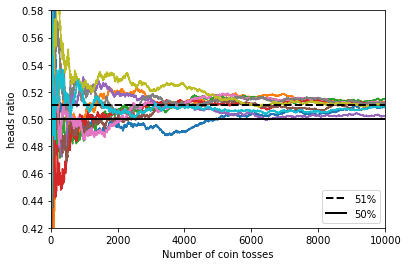

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%') #51% 경계선
plt.plot([0, 10000], [0.50, 0.50], 'k-', linewidth=2, label='50%') #50% 경계선
plt.xlabel('Number of coin tosses')
plt.ylabel('heads ratio')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58]) #x축 0~10000, y축 0.42~0.58
plt.show()

 - 던지는 횟수가 증가하면서 앞면이 나오는 비율은 51%에 가까워짐 

### 예측기의 개념으로 생각 
- 각 51%의 성능을 가진 1000개의 분류기를 결합해 앙상블을 만든다 가정 
- 결합 시 75% 정도까지 성능을 기대할 수 있음 
#### - 하지만 
- 분류기들이 서로 완전히 독립적이고 같은 데이터로 학습하지 않음 등 관계 없는 오류를 가질 때만 성립 
- 같은 타입의 오류를 만들면 잘못된 클래스에 투표가 많아져 앙상블의 성능을 저하시킬 수 있음 

### 주의 
#### - 앙상블 기법은 예측기들이 최대한 서로 독립적일때 최고의 성능을 보임 
#### - 분류기의 다양성을 위해서는 매우 다른 알고리즘을 통해 학습하는 방법이 있음 
- 매우 다른 종류의 오류를 만들어 앙상블의 성능이 발전될 것을 기대할 수 있음

#### - Sickit-learn의 VotingClassifier() 사용하기
- moons 데이터를 사용, 3개의 다양한 분류기로 구성된 Voting classifier 생성, 학습

In [3]:
#학습데이터 만들기
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#개별분류기
log_clf = LogisticRegression(random_state=42)  #로지스틱회귀 모델
rnd_clf = RandomForestClassifier(random_state=42) #랜덤포레스트 모델
svm_clf = SVC(random_state=42) #서포트백터머신 모델 

#앙상블
voting_clf = VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard') #추정기 = ('이름', 생성이름)

#학습
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

- 분류기들의 정확도 비교 

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train) #학습
    y_pred = clf.predict(X_test) #예측 
    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


- VotingClassifier(앙상블)가 가장 정확도가 높음 

### - Scikit-learn에서는 hard voting, soft voting 지원 
- hard voting : 개별 분류기의 결과에서 단순 투표 
- soft voting : 가중치 투표, 개별 분류기의 조건부 확률 사용  
    - 모든 분류기에 predict_proba() (클래스의 확률을 예측하는) 메소드가 있어야 함
    - 확률이 높은 클래스에 가중치를 높게 부여해서 hard voting보다 높은 성능을 얻을 수 있음 

In [6]:
#개별분류기
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42) #probability 설정 

#앙상블
voting_clf = VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft') #soft voting 설정 

#학습
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [7]:
#soft_voting의 성능 측정 
voting_clf.fit(X_train, y_train) #학습
y_pred = voting_clf.predict(X_test) #예측 

print(voting_clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.912


- hard voting보다 성능이 좋음 

## 2. Baggind and Pasting
### : 모든 예측기에 사용한 알고리즘은 같지만 학습데이터를 샘플링해 각 예측기에 다른 데이터를 학습시키는 방법

### - Bagging 
- 학습데이터 샘플링시 대체가 있음 

#### ※
<img src = 'image\ch7\p_boosting.png'>

### - Pasting
- 학습데이터 샘플링시 대체가 없음 


<img src = 'image\ch7\bagging.png'> 

#### ※
<img src = 'image\ch7\p_bagging2.png'> 

- 모든 예측기의 학습이 끝나면, 결과를 결합하여 새로운 데이터 예측
- 결합시, 분류에는 다수결, 회귀에는 평균을 주로 사용 
- 데이터 샘플링을 사용하기 때문에 각 분류기로 보면 편향이 높을 수 있지만 결과를 결합함으로써 편향과 변동을 낮춤 
- 실제 앙상블 사용시, 결과는 개별 학습기의 결과와 편향은 비슷하지만 더 낮은 변동을 가짐 
- 예측 및 학습을 병렬로 수행 가능 -- 확장성이 매우 좋음 


### 1) Bagging and Pasting in Scikit-Learn

#### - Scikit-learn의 BaggingClassifier

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
    #500개의 DT를 bagging으로 앙상블 
    #pasting 사용 --> bootstrap = False
    #n_jobs : 병렬적으로 사용할 cpu의 개수 설정 (-1: 사용가능한 모든 cpu를 사용하겠다)
    
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

- BaggingClassifier는 분류기에 prdict_proba()메소드가 있을 경우 (soft voting이 가능할 경우) 자동으로 hard voting이 아닌 soft voting 수행 

#### - 단일 분류기와 Bagging 분류기의 결정경계 차이점 

In [9]:
from matplotlib.colors import ListedColormap

#결정경계 플롯
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    
    x1s = np.linspace(axes[0], axes[1], 100) #x1축을 100분할
    x2s = np.linspace(axes[2], axes[3], 100) #x2축을 100분할
    x1, x2 = np.meshgrid(x1s, x2s) #(100, 100), (100, 100)
    
    X_new = np.c_[x1.ravel(), x2.ravel()] #새로운 데이터 
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)##
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18)

In [10]:
a, b = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1, -1.5, 100))
b.shape

(100, 100)

In [11]:
#DT분류기
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

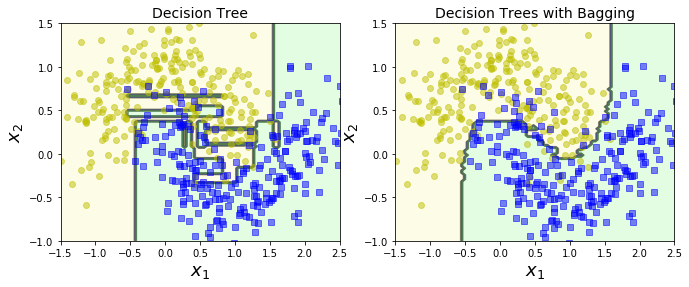

In [12]:
plt.figure(figsize=(11,4))

#DT분류기
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

#앙상블(Bagging)분류기
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

- 단일 분류기보다 앙상블이 더 일반화된 예측을 수행함 
- 비슷한 편향을 보이지만 앙상블이 변동은 더 적음 

#### -  Bagging의 특징
- Bagging은 다양한 subset을 학습하기 때문에 예측기들이 Pasting보다 약간 높은 편향을 가질 수 있음 
    - 하지만 이것은 예측기간의 상관관계가 낮아지면서 앙상블의 변동이 줄어들게 함 
- Bagging은 전반적으로 성능이 더 좋아 더 많이 사용됨 
- 여건이 된다면 cross validation을 사용해 Bagging과 Pasting을 비교하여 더 나은 것을 선택해도 됨 

### 2) Out-of-Bag Evvaluation

#### - Bagging 사용 시 전혀 사용되지 않는 데이터 발생 가능 (샘플링되지 않은 데이터) 
#### - oob(out-of-bag) : 샘플링되지 않은 데이터 
- 학습에 사용되지 않은 데이터이기 때문에 평가에 사용될 수 있음 
- 별도의 유효성 검증 데이터나 cross-validation이 필요하지 않음 
- 각 예측기의 oob 평가 결과를 평균하여 앙상블 자체의 성능을 평가할 수 있음 

#### - BaggingClassifier() 생성 시 (oob-score = True)로 설정 가능  


In [13]:
#앙상블 자체에서 성능 평가 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    oob_score=True, ##oob_score=True
    max_samples=100,bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.92533333333333334

In [14]:
#테스트 데이터를 사용해 성능 .평가 
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


- 비슷한 결과(정확도)를 보임 

### 3) Random Patches and Random Subspaces
#### - BaggingClassifier()는 특징 샘플링도 지원 
- 하이퍼파라미터 max_features, bootstrap_features로 제어됨 
- 데이터 샘플링과 같은 방식으로 특징 샘플링 진행 
- 그러므로 각 예측기는 입력된 특징의 임의의 subset으로 학습 
- 고차원 데이터(이미지)를 다룰 때 유용
- 특징 샘플링은 적은 변동을 위해 편향을 살짝 더 가지게되면서 예측기의 다양성을 확보할 수 있음 

#### - Random Patches VS Random Subspaces
- Random Patches : 학습 데이터와 특징을 모두 샘플링 
- Random Subspaces : 학습 데이터는 샘플링하지 않고 특징만 샘플링 


In [15]:
B = BaggingClassifier()
B
#특징 샘플링의 기본값은 False

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

## 3. Random Forests
#### - DT의 앙상블이며 일반적으로 Bagging 기법으로 학습 
#### - max_samples는 학습데이터의 크기에 의해 결정 
#### - 분류기 생성 방법 
- 1) BaggingClassifier 생성해 DecisionTreeClassifier를 넘겨준다 
- 2) RandomForestsClassifier를 사용한다 
- 회귀도 마찬가지 

### 1) Scikit-learn의 RandomForestsClassifier() 
- 최대 리프노드가 16개로 제한된 500개의 DT 앙상블 

In [16]:
#2)RandomForestClassifier()
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train) #학습

y_pred_rf = rnd_clf.predict(X_test) #예측 

#### - RandomForestsClassifier의 하이퍼파라미터 
- 트리를 제어하기 위한 DecisionTreeClassifier의 모든 하리퍼파라미터 
- 앙상블을 제어하기 위한 BaggingClassifier의 모든 하이퍼파라미터

#### - RandomFroest 알고리즘은 트리를 증가시킬 때 무작위성을 추가함 
- 특징의 임의의 subset에서 최적의 특징으로 분할 
- 더 높은 편향은 변동을 낮아지게 하여 예측기들의 다양성이 확장되고 전반적으로더 나은 모델이 생성됨 

In [17]:
R = RandomForestClassifier()
R

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### - RandomForests 두가지 생성 방법 비교 

In [18]:
#1)BaggingClassifier()
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train) #학습

y_pred = bag_clf.predict(X_test) #예측

In [19]:
# 1번 방법과 2번 방법의 예측값 비교 
# 일치하면 1, 모든 값을 더해서 전체 예측값 중 일치된 비율 
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.97599999999999998

- 거의 비슷함

### 2) Extra-Trees (Extremely Randomized Trees Ensemble)
#### - RandomForests는 특징의 임의의 subset에서 최적의 특징으로 분할 
#### - ExtraTrees는 최적 임계치가 아닌 각 특징의 임의의 임계치를 사용해 분할 
- 트리의 무작위성이 높음 
- 편향이 높아지면서 변동이 낮아짐 
- 오랜 시간이 걸리는 최적의 임계치를 찾는 작업을 안해도 되어 RandomForests보다 더 빠름  

#### - Scikit-learn의 ExtraTreesClassifier()로 생성 가능 
- API는 RandomForestsClassifier()와 동일 
- 회귀도 마찬가지 

#### - RandomClassifier와 ExtraClassifier 중 어떤게 더 나은지 사전에 알기는 어려움 
- 두가지를 모두 시도해보고 cross-validation과 grid_serch를 사용해 비교봐야 알 수 있음 

In [23]:
#RandomForestsClassifier()
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

%time y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

Wall time: 413 ms
0.92


#### - Scikit-learn의 ExtraTreeClassifier()

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
extra_clf.fit(X_train, y_train)

%time y_pred_ex = extra_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_ex))

Wall time: 206 ms
0.92


- 속도는 ExtraTrees가 더 빠름 

### 3) Feature Importance
#### - DT에서 주요 특징은 루트노드에 가까움 
- 노드의 깊이로 특징의 중요도를 파악할 수 있음 

#### -즉  RandomForests는 각 특징들의 상대적 중요도 파악 가능  
- Scikit-learn은 자동으로 학습 후 모든 특징에 대해 상대적 중요도를 계산함 
    - 각각의 특징의 중요도 점수를 계산하고 총 합이 1이 되되록 스케일링 
    - feature_importances_로 확인 가능 
    
    
- 특징 선택을 해야 할때 어떤 특징이 중요한 특징인지 빨리 이해할 수 있도록 도와줌 

#### - iris 데이터로 각 특징의 중요도 파악하기 

In [25]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target']) #학습

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


- 꽃잎의 길이가 가장 중요도가 높음 

#### - MNIST 데이터로 각 픽셀의 중요도 파악하기 

In [27]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNI
                     ST original')
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"]) #학습

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
mnist['data'].shape

(70000, 784)

In [73]:
import matplotlib 

def plot_digit(data):
    image = data.reshape(28, 28) 
    plt.imshow(image, cmap = matplotlib.cm.hot,interpolation="nearest")
    plt.axis("off")

In [75]:
print(matplotlib.__version__)

2.0.2


In [77]:
print(np.__version__)

1.13.3


In [70]:
def plot_digit2(data):
    image = data.reshape(28, 28) 
    plt.imshow(image, cmap = matplotlib.cm.hot) #interpolation="nearest")
    plt.axis("off")

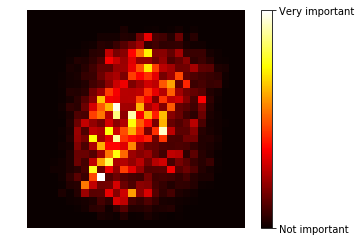

In [71]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

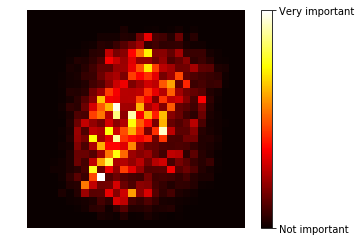

In [72]:
plot_digit2(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

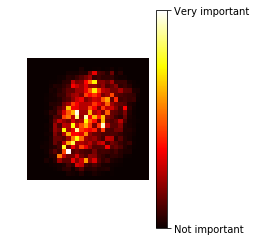

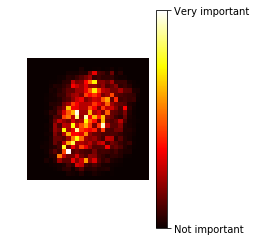

In [69]:
plt.subplot(121)
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()


plt.subplot(122)
plot_digit2(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

In [82]:
rnd_clf.feature_importances_

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   3.09335168e-06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.01002598e-06,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [32]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

## 4. Boosting
#### - 여러 양한 분류기들을 결합하여 강한 분류기로 만드는 앙상블 기법 
#### - 각 예측기들이 이전의 예측기들의 오류를 수정하면서 순차적으로 학습

### 1) AdaBoost
#### - 이전 예측기에서 underfit(오분류)된 데이터에 가중치를 부여해 다음 예측기가 학습
- 반복 
<img src = 'image\ch7\boosting.png'> 

#### - moons 데이터로 만든 5개의 순차적 예측기의 결정경계 보기 
- 예측기는 RBF커널로 정규화된 SVM분류기 사용 

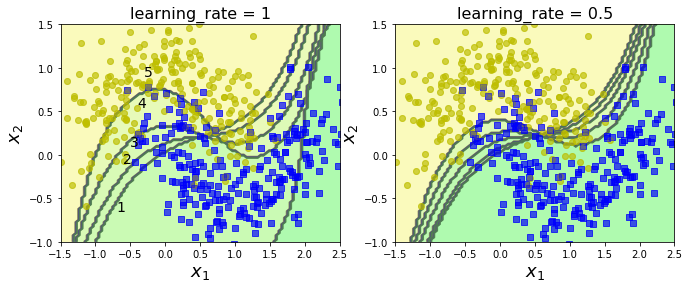

In [33]:
m = len(X_train)

plt.figure(figsize=(11, 4))

for subplot, learning_rate in ((121, 1), (122, 0.5)):
    
    sample_weights = np.ones(m) #초기 데이터 가중치는 모두 1
    for i in range(5): #5개의 분류기를 순차적으로 사용 
        plt.subplot(subplot)
        
        #svm분류기 사용 
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) #학습
        y_pred = svm_clf.predict(X_train) #예측
        
        #가중치 업데이트 
        sample_weights[y_pred != y_train] *= (1 + learning_rate) 
        #오분류된 데이터의 가중치 = 기존 가중치 * (1+학습률) 
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)


plt.show()

- 왼쪽 : 학습률이 1인 분류기 
- 오른쪽 : 학습률이 0.5(절반)인 분류기 
    - 모든 반복에서 가중치 업데이트시 절반만큼 증가 

#### - 모든 예측기의 학습이 끝나면 예측기마다 데이터에 다른 가중치를 갖는 것을 제외하고는 bagging, pasting과 유사한 예측을 함 

#### - 단점 
- 이전 예측기가 학습되어야만 다음 예측기가 학습이 가능함
- 병렬적 또는 부분적 작업이 불가능함 
- 확장성이 좋지 않음 

#### - Adaboost 알고리즘 
- 초기에 각 데이터의 가중치 w(i)는 1/m로 설정 (m은 데이터의 개수) 


- 가중오류율 
<img src = 'image\ch7\adaboost.png'> 
   - 예측기의 예측이 틀린 데이터의 가중치들의 합 / 전체 데이터의 가중치 합
   
   
- j번째 예측기의 가중치 
<img src = 'image\ch7\adaboost2.png'> 
   - 에타는 학습률 
   - 예측기의 정확도가 높을수록 그 예측기의 가중치는 높음 
   - 예측기가 무작위로 추측하는 경우(약한 분류기) 예측기의 가중치는 0에 가까움 
   - 최악의 경우 (무작위 추측보다 정확도가 낮을때)에는 가중치는 음수가 됨 
   
   
- i번째 데이터의 가중치 업데이트 
<img src = 'image\ch7\adaboost3.png'>
   - 예측기의 예측이 맞으면 데이터의 가중치는 그대로 
   - 틀리면 가중치 업데이트 (예측기의 가중치 사용) 
   - 업데이트 후 모든 데이터의 가중치는 정규화됨 (전체 가중치의 합으로 나눠짐) 
   
   
- 원하는 수의 예측기에 도달하거나 완벽한 예측기가 발견될때까지 반복


- 예측된 클래스는 가중화된 투표를 많이 받은 클래스 
<img src = 'image\ch7\adaboost4.png'>
   - N : 예측기의 개수 
   - k : 클래스 
   

#### - SAMME
- SAMME
    - 실제 sklearn에서는 Adaboost의 다중 클래스 버전인 SAMME 알고리즘 사용 
    - SAMME에 클래스가 2개밖에 없다면 Adaboost와 동일 
 
 
- SAMME.R 
    - 예측기가 클래스 확률을 측정할 수 있다면 예측값이 아닌 클래스 확률에 의존적인 SAMME 사용 가능 
    - 일반적으로 SAMME보다 성능이 더 좋음
 
 
#### - Scikit-learn의 AdaBoostClassifier()
- 200개의 결정 stumps를 사용한 Adaboost 
     - 결정 stumps : 최대 깊이가 1인 트리, 단일 결정노드 1개와 리프노드 2개로 이루어짐 
     - AdaBoostClassifier의 기본 추정기 

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(X_train, y_train) #학습

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

#### - AdaBoost기법을 사용했을 때 overfitting이 발생하면 
- 추정기의 개수를 줄임 
- 기본 추정기에 제약을 더함 

### 2) Gradient Boosting
#### - Adaboost와 동일하게 예측기를 순차적으로 작동하며 이전의 학습기의 문제를 다음의 학습기에서 바로 잡음 
#### - 하지만, 모든 반복에서 데이터의 가중치를 조절하지 않음 
#### - 이전 예측기에 의해 생성된 잔여 오류를 새로운 예측기에 적용함 
- ※ 첫번째 모델 구축 후 그 모델이 생성한 오류에 맞춘 모델 생성, 또 그 모델의 오류에 맞춘 모델 생성, 반복 후 모두 결합 

#### - 예제 
- DT를 기본 예측기로 사용하는 간단한 회귀 예제 (Gradient Tree Boosting, Gradient Boosted Regression Tree(GBRT))

In [35]:
#노이즈가 심한 이차 데이터 
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

- 첫번째 DT에 데이터 학습 

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

- 첫번째 예측기에 의한 잔여오류에 대해 두번째 DT가 학습 

In [37]:
y2 = y - tree_reg1.predict(X) #정답값 - 첫번째 DT의 예측값 (잔여오류)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

- 두번째 예측기에 의한 잔여오류에 세번째 DT학습 

In [38]:
y3 = y2 - tree_reg2.predict(X) #두번째 DT의 잔여오류
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

- 새로운 데이터에 대해 예측 

In [39]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
#모든 트리 모델의 예측을 합침 

y_pred

array([ 0.75026781])

In [41]:
#예측 시각화 
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500) #500개로 분할
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors) #예측
    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

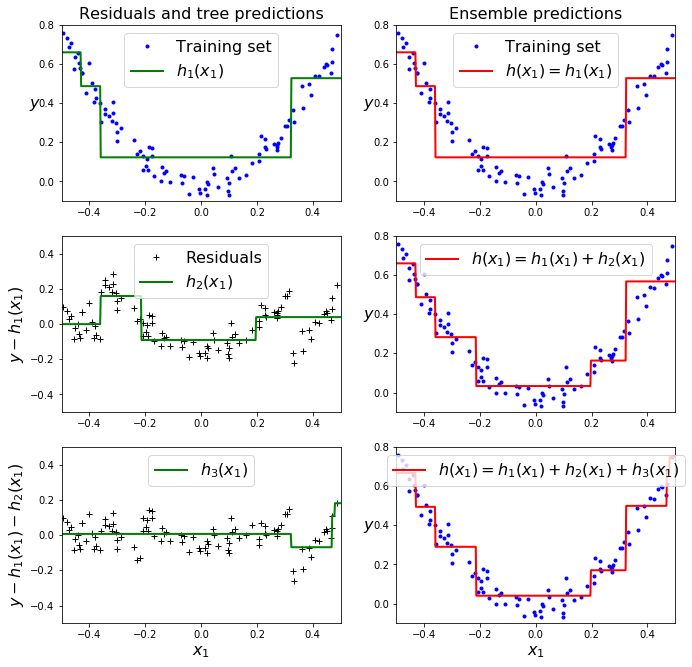

In [42]:
plt.figure(figsize=(11,11))

#첫번째 DT
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

#두번째 DT
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

#DT1 + DT2
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

#3번째 DT
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

#DT1 + DT2 + DT3
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- DT의 개수가 증가할수로 모델의 성능이 좋아짐 

#### - Scikit-learn의 GradientBoostingRegressor() 사용하기 
- RandomForests와 유사한 하이퍼 파라미터를 가짐 
    - DT의 확장을 제어하는 하이퍼파라미터를 가짐 (최대깊이 등)
    - 앙상블을 제어하는 하이퍼파라미터를 가짐 (추정기의 개수 등)

In [43]:
#위와 같은 작업 
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42) #DT 3개 
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
gbrt.predict(X_new) 
#같은 결과

array([ 0.75026781])

#### - learning_rate 하이퍼 파라미터 
- 각 트리의 기여도 조정 
- Shrinkage 정규화기법
    - 낮은 값(0.1)으로 설정할 경우 많은 DT(추정기)가 필요하지만 예측 성능은 일반적으로 좋음 



In [45]:
#학습률을 느리게 설정한 경우 
#트리의 기여도가 낮음 
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

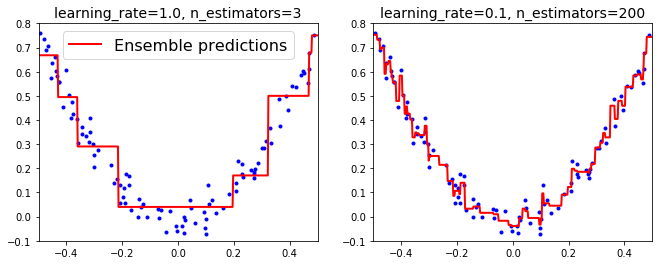

In [46]:
plt.figure(figsize=(11,4))

#학습률 = 1.0 (빠름)
plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

#학습룰 = 0.1 (느림)
plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

- 학습속도를 낮추면 더 많은 추정기가 필요하다 
- 너무 많은 추정기는 overfitting을 유발함

#### - 최적의 추정기(트리) 수 찾기 
- early stopping 사용 
- 구현방법 
    - 1) 많은 추정기를 학습시킨 후 학습의 각 단계에서 cross validation 검사로 최적의 트리 수 찾음 
    - 2) 학습을 실제로 일찍 중단 

In [ ]:
#1) 
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42) #120개의 DT
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] #오류 측정 방법  : MSE사용 

bst_n_estimators = np.argmin(errors) #오류가 최소일 때의 트리 개수가 최적의 개수 

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42) #최적의 트리개수로 만든 모델
gbrt_best.fit(X_train, y_train)#학습 

In [48]:
min_error = np.min(errors)

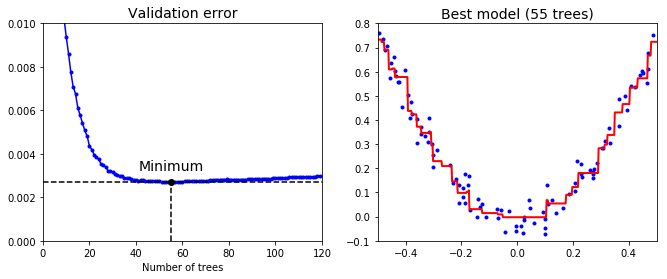

In [49]:
plt.figure(figsize=(11, 4))

#트리의 개수가 10개씩 증가할 때마다 validation error 표시 
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--") #최소오류 경계 
plt.plot(bst_n_estimators, min_error, "ko") #최소오류가 되는 지점 표시 
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14) 
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

#최적의 트리 개수로 생성한 모델 
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

- validation errors는 트리가 55개 일 때 가장 적음 
- 트리의 개수가 55개 일 때 성능이 가장 좋음 

In [50]:
#2) 
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42) #(warm_start = True)

min_val_error = float("inf") #float('inf') = 무한
error_going_up = 0

for n_estimators in range(1, 120): #120개의 분류기를 순차적으로 작업 
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train) #학습
    y_pred = gbrt.predict(X_val) #예측
    
    val_error = mean_squared_error(y_val, y_pred) #유효성오류 
    
    if val_error < min_val_error: #유효성오류가 최소오류보다 작으면 
        min_val_error = val_error #그 유효성오류가 최소오류가 됨 
        error_going_up = 0 #count 그대로 
        
    else: #유효성오류가 최소오류보다 크면 (최소오류가 가장 작으면)
        error_going_up += 1 #count+1
        if error_going_up == 5: #5번이되면 학습 중지
            break  # early stopping

- 실제로 일찍 중단 
- warm_start=True : fit() 메소드 호출 시, 기존 트리를 유지하면서 점진적으로 학습 허용 
- validation error가 연속적으로 5회 반복되지 않으면 학습 중지 

In [51]:
print(gbrt.n_estimators)

61


#### - GradientBoostingRegressor() 의 하이퍼파라미터 

- Stochastic Gradient Boosting 기법
    - GradientBoostingRegreesor() 클래스의 subsample 하이퍼파라미터 조정
        - 각 트리의 학습에 사용할 학습 데이터의 비율 지정 
        - subsample=0.25 이면 각 트리는 무작위로 선택된 학습데이터의 25%로 학습됨 
        - 속도가 빠름 
    
    
- 다른 비용함수 사용 
    - loss 하이퍼 파라미터 조정 
    
    
 

## 5. Stacking
#### - 앙상블의 예측기들의 결과를 결합하는 trivial function(hard-voting) 대신 모델을 학습시키자 
#### - 계층적 작업 

<img src = 'image\ch7\stacking.png'> 
- 새로운 데이터에 회귀 작업을 수행하는 앙상블 
- 아래 3개의 예측기는 각각 다른값을 예측함 
- 최종예측기 blender는 그 예측값을 입력값으로 최종예측을 진행함 

### - hold-out set
<img src = 'image\ch7\stacking2.png'> 
#### -  blender를 학습시키는 일반적인 방법 
- 학습 데이터를 두개의 subset으로 나눔 
- subset1은 layer1의 예측기들의 학습에 사용 
- subset2(hold-out된, 보류된)는 layer1의 예측기들의 예측에 사용 
- layer1 예측기들의 예측값을 입력 특징으로 새로운 학습데이터 생성, 목표값(subset2)은 유지 

<img src = 'image\ch7\stacking3.png'> 
- blender(최종예측기)는 만들어진 새로운 학습데이터에 대해 학습

#### - 여러 다른 blender에도 적용 가능 
<img src = 'image\ch7\stacking4.png'>
- 학습 데이터를 3개의 subset으로 나눔 
- subset1은 layer1의 학습을 위해 사용 
- subset2는 layer1의 예측을 위해 사용되고 그 예측값으로 layer2에 학습할 새로운 학습데이터를 만드는데 사용 
- subset3는 layer2의 예측을 위해 사용되고 그 예측값으로 layer3에 학습할 새로운 학습데이터를 만드는데 사용 



#### - Scikit-learn은 Stacking을 직접 지원하지 않음 
- 직접 구현은 어렵지 않음 
- 오픈소스 brew 사용 가능 
